# Imports

In [61]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
sys.path.append('./../..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator

import math

import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulator

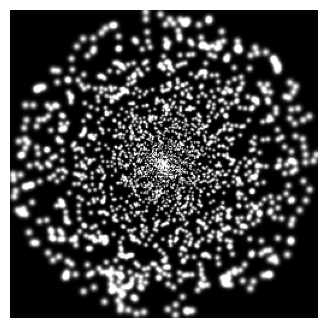

In [229]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')

# # Get phosphene coordinates
# n_phosphenes = 3000

# seed = 42
# rng = np.random.default_rng(seed) if seed is not None else None

# phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes, rng=rng)
# open from pickle file:
# path = '../electrode_schemes/defaultcoordinatemap_1024.pickle'
# path = '../electrode_schemes/4utaharrays.pickle'
# path = '../electrode_schemes/1utaharray.pickle'
path = '../electrode_schemes/neuralinkshank.pickle'
with open(path, 'rb') as f:
    phosphene_coords = pickle.load(f)

n_phosphenes = len(phosphene_coords)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] / 2 # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda().detach() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.figure(figsize=(4, 4))
plt.imshow(phosphenes.cpu()[0], cmap='gray')
plt.axis('off')
plt.show()

# Uniformity

Loss = 0.0034: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 108.87iter/s]


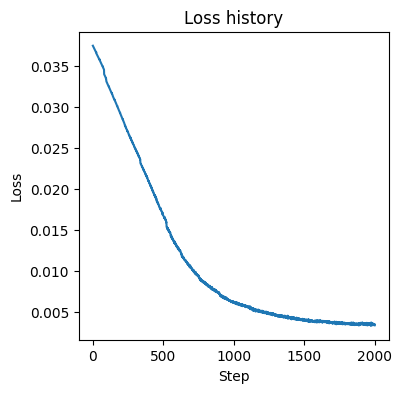

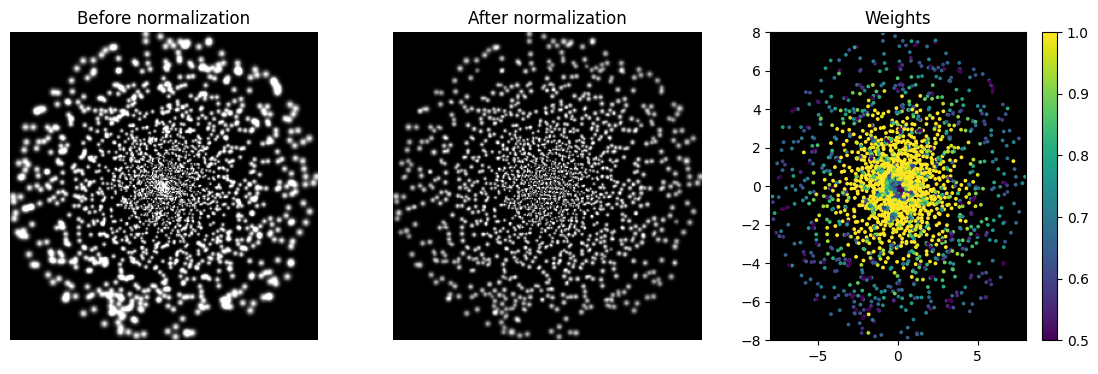

Percentage of amplitude: 80.35%


In [230]:
from phosphene.uniformity import DynamicAmplitudeNormalizer

stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=2,
    scale=0.001,
    A_min=amplitude/2,
    A_max=amplitude,
    learning_rate=0.002,
    steps=2000,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init, verbose=True)
stim_weights = normalizer.weights

# plot the loss_history from the normalizer
plt.figure(figsize=(4, 4))
plt.plot(normalizer.loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu()[0], cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu()[0], cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# extend the axes to the full image size
fov = simulator.params['run']['view_angle']
plt.xlim(-fov/2, fov/2)
plt.ylim(-fov/2, fov/2)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# percentage of amplitude compared to full amplitude
print(f'Percentage of amplitude: {stim_weights.sum() / simulator.num_phosphenes*100:.2f}%')

# Phosphene Density Maps

In [231]:
from phosphene.density import VisualFieldMapper

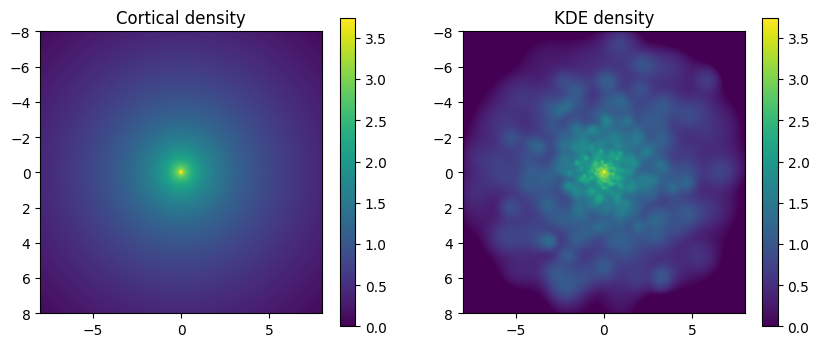

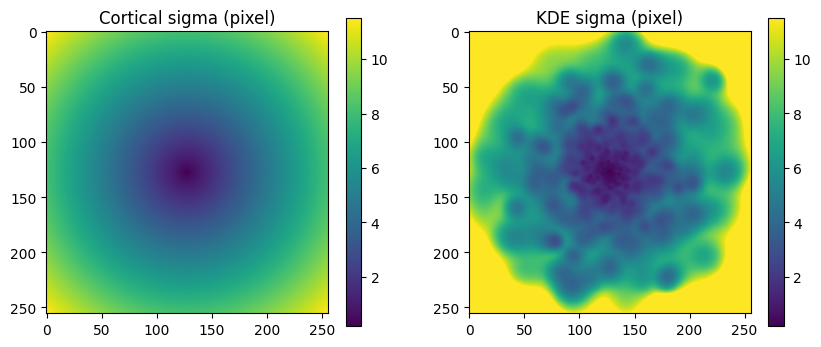

In [232]:
mapper = VisualFieldMapper(simulator=simulator)

# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=n_phosphenes)
sigma_cortical_fov = mapper.build_sigma_map_from_density(density_cortical, space="fov")
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=5, alpha=1.0, total_phosphenes=n_phosphenes)
sigma_kde_fov = mapper.build_sigma_map_from_density(density_kde, space="fov")
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

# show density maps
fov = params['run']['view_angle']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(density_cortical), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmin=0)
plt.colorbar()
plt.title('Cortical density')

plt.subplot(1, 2, 2)
plt.imshow(np.log10(density_kde), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmax=np.log10(density_cortical.max()), vmin=0)
plt.colorbar()
plt.title('KDE density')
plt.show()

# plot sigma_cortical_pix, sigma_kde_pix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

# Image processing for Phosphene Vision

In [233]:
from spatial_frequency.components.SeparableModulated2d import SeparableModulatedConv2d
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.datasets import CocoDetection

# 1) Define your weighted‐grayscale Lambda
rgb_weights = torch.tensor([0.2126, 0.7152, 0.0722]).view(3,1,1)
to_weighted_grayscale = transforms.Lambda(
    lambda img: (img * rgb_weights).sum(dim=0, keepdim=True)
)

# 2) Build your full pipeline
t = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),            # → [C,H,W] in [0,1]
    to_weighted_grayscale,            # → [1,H,W] weighted luma
])

folder = '/projects/prjs0344/Dynaphos/data/example_faces_LaPa/'
# folder = '/projects/prjs0344/Dynaphos/data/SUN/SUN397'

data_loader = DataLoader(
    ImageFolder(folder, transform=t),
    batch_size=1,
    shuffle=False
)

# where you unzipped train2017/val2017 and annotations/
# data_root = "/projects/prjs0344/Dynaphos/data/coco"
# img_dir    = os.path.join(data_root, "val2017")
# ann_file   = os.path.join(data_root, "annotations", "instances_val2017.json")

# coco_val = CocoDetection(root=img_dir,
#                          annFile=ann_file,
#                          transform=t)
# data_loader = DataLoader(coco_val, batch_size=1, shuffle=False)

In [234]:
def robust_percentile_normalization(electrode, amplitude, threshold, low_perc=5, high_perc=95, gamma=1.0):
    """
    Normalize the stimulation vector in a robust, contrast-preserving way.

    This function performs the following steps:
      1. Subtracts a given threshold (values below threshold become 0).
      2. Computes low and high percentiles (e.g., 5th and 95th) of the resulting values.
      3. Linearly scales values between these percentiles to [0, 1], then applies an optional gamma correction.
      4. Scales the result to the desired amplitude.

    Args:
        electrode (torch.Tensor): Input stimulation values.
        amplitude (float): Desired maximum amplitude.
        threshold (float): Activation threshold (e.g. your activation_threshold).
        low_perc (float): Lower percentile (default 5).
        high_perc (float): Upper percentile (default 95).
        gamma (float): Gamma exponent for power-law scaling (default 1.0 means linear scaling).
        
    Returns:
        torch.Tensor: Normalized stimulation values, with zeros preserved.
    """
    # Subtract threshold and clamp to 0 so that values below threshold remain 0.
    above_thresh = electrode - threshold
    above_thresh = torch.clamp(above_thresh, min=0.0)
    
    # Compute robust lower and upper bounds using percentiles.
    # Use torch.quantile (available in PyTorch 1.7+; adjust if needed).
    low_val = torch.quantile(above_thresh, low_perc / 100.0)
    high_val = torch.quantile(above_thresh, high_perc / 100.0)
    
    # Avoid division by zero if high_val == low_val.
    range_val = high_val - low_val + 1e-8

    # Linearly map values in the range [low_val, high_val] to [0, 1]
    normalized = (above_thresh - low_val) / range_val
    normalized = torch.clamp(normalized, 0.0, 1.0)

    # Apply gamma correction to adjust contrast if needed.
    normalized = normalized ** gamma

    # Scale to the desired amplitude.
    normalized = normalized * amplitude

    return normalized


# Dilation is used for the reg-loss on the phosphene image: phosphenes do not have to map 1 on 1, small offset is allowed.
def dilation5x5(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[[0., 0., 1., 0., 0.],
                              [0., 1., 1., 1., 0.],
                              [1., 1., 1., 1., 1.],
                              [0., 1., 1., 1., 0.],
                              [0., 0., 1., 0., 0.]]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

def dilation3x3(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[
                              [ 0, 1., 0.],
                              [ 1., 1., 1.],
                              [ 0., 1., 0.],]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

In [235]:
sigma_map_tensor = torch.tensor(sigma_kde_pix).float().cuda().detach()

mod_layer = SeparableModulatedConv2d(
    in_channels=1,
    sigma_map=sigma_map_tensor
).cuda()
mod_layer.eval()

SeparableModulatedConv2d()

In [236]:
def rand_perlin_2d(shape, res, fade = lambda t: 6*t**5 - 15*t**4 + 10*t**3):
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    
    grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(0, res[1], delta[1])), dim = -1) % 1
    angles = 2*math.pi*torch.rand(res[0]+1, res[1]+1)
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim = -1)
    
    tile_grads = lambda slice1, slice2: gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]].repeat_interleave(d[0], 0).repeat_interleave(d[1], 1)
    dot = lambda grad, shift: (torch.stack((grid[:shape[0],:shape[1],0] + shift[0], grid[:shape[0],:shape[1], 1] + shift[1]  ), dim = -1) * grad[:shape[0], :shape[1]]).sum(dim = -1)
    
    n00 = dot(tile_grads([0, -1], [0, -1]), [0,  0])
    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1],[1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1,-1])
    t = fade(grid[:shape[0], :shape[1]])
    return math.sqrt(2) * torch.lerp(torch.lerp(n00, n10, t[..., 0]), torch.lerp(n01, n11, t[..., 0]), t[..., 1])

In [242]:
import torch
import numpy as np
import cv2

def make_stim_phos(simulator, stim: torch.Tensor, amplitude, threshold, stim_weights):
    """
    stim: [B, C, H, W]
    returns: (stim, phos) both [B, C, H, W]
    """
    simulator.reset()
    elec = simulator.sample_stimulus(stim, rescale=True)
    elec = robust_percentile_normalization(
        elec,
        amplitude,
        threshold=threshold,
        low_perc=5,
        high_perc=90,
        gamma=2/3
    )
    elec = elec * stim_weights
    phos = simulator(elec)

    # ensure [B,C,H,W]
    if phos.dim() == 2:          # [H,W]
        phos = phos.unsqueeze(0).unsqueeze(0)
    elif phos.dim() == 3:        # [C,H,W]
        phos = phos.unsqueeze(0)
    return stim, phos

image_processing_dict = {}
threshold = params['thresholding']['rheobase']

for idx, (images, _) in enumerate(data_loader):
    images = images.cuda()             # [1,1,H,W]
    orig = images                    

    # DoG
    dog = mod_layer(orig)
    dog = dog.detach().cpu().clip(0, None)
    dog = (dog - dog.min())/(dog.max()-dog.min())
    dog = dog.cuda()

    # Canny
    npimg = (orig[0,0].cpu().numpy()*255).astype(np.uint8)
    ce = cv2.Canny(npimg,150,280).astype(np.float32)  # [H,W]
    # dilate 3x3
    ce = dilation3x3(torch.from_numpy(ce).unsqueeze(0)).squeeze(0).cpu().numpy()
    ce = torch.from_numpy(ce / (ce.max()+1e-8)).unsqueeze(0).unsqueeze(0).cuda()

    # Random Perlin (fixed)
    rp = rand_perlin_2d((256,256),(4,4))    # returns a torch.Tensor [H,W]
    rp = rp.float()                         # ensure float
    rp = (rp - rp.min())/(rp.max()-rp.min())
    rp = rp.unsqueeze(0).unsqueeze(0).cuda()  # [1,1,H,W]

    # stimulate & simulate
    stim_gs, phos_gs   = make_stim_phos(simulator, orig,  amplitude, threshold, stim_weights)
    stim_dog, phos_dog = make_stim_phos(simulator, dog,   amplitude, threshold, stim_weights)
    stim_ce, phos_ce   = make_stim_phos(simulator, ce,    amplitude, threshold, stim_weights)
    stim_rp, phos_rp   = make_stim_phos(simulator, rp,    amplitude, threshold, stim_weights)

    image_processing_dict[idx] = {
        'image': orig,            
        'grayscale': {
            'stim': stim_gs,       
            'phosphenes': phos_gs 
        },
        'DoG_response': {
            'stim': stim_dog,      
            'phosphenes': phos_dog
        },
        'canny_edge': {
            'stim': stim_ce,       
            'phosphenes': phos_ce
        },
        'random': {
            'stim': stim_rp,       
            'phosphenes': phos_rp
        }
    }

    if idx == 100:
        break


In [243]:
torch.use_deterministic_algorithms(False)

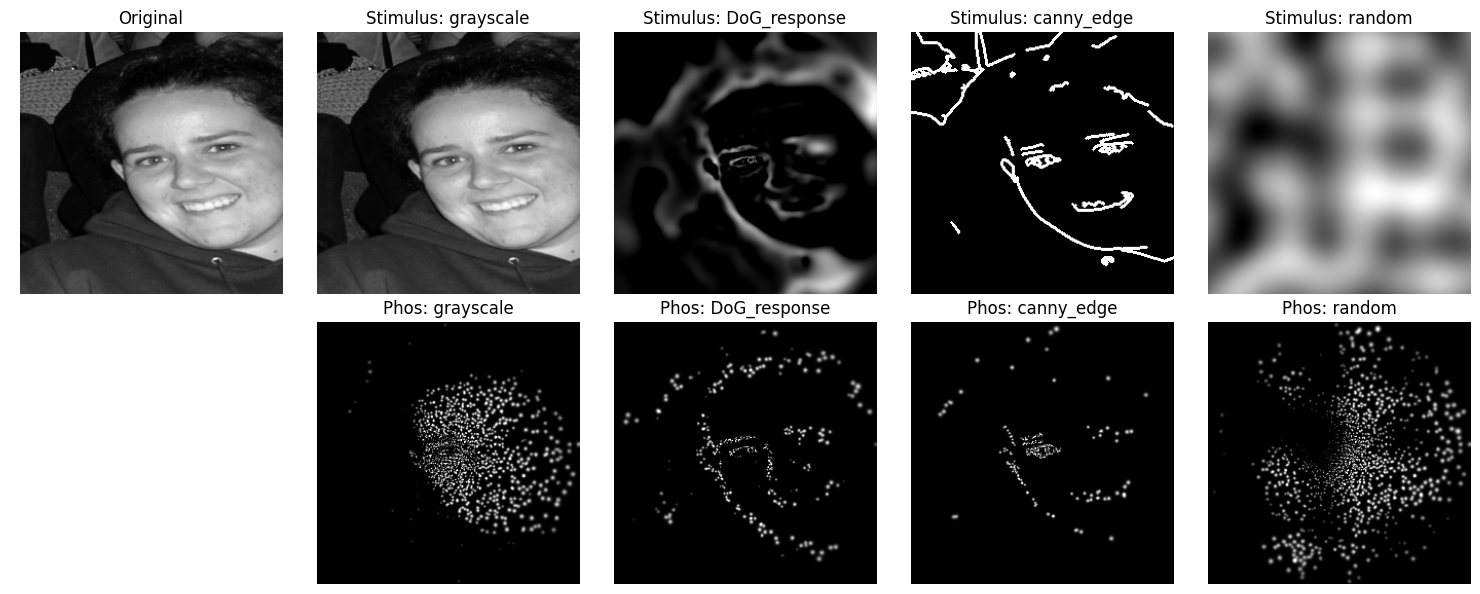

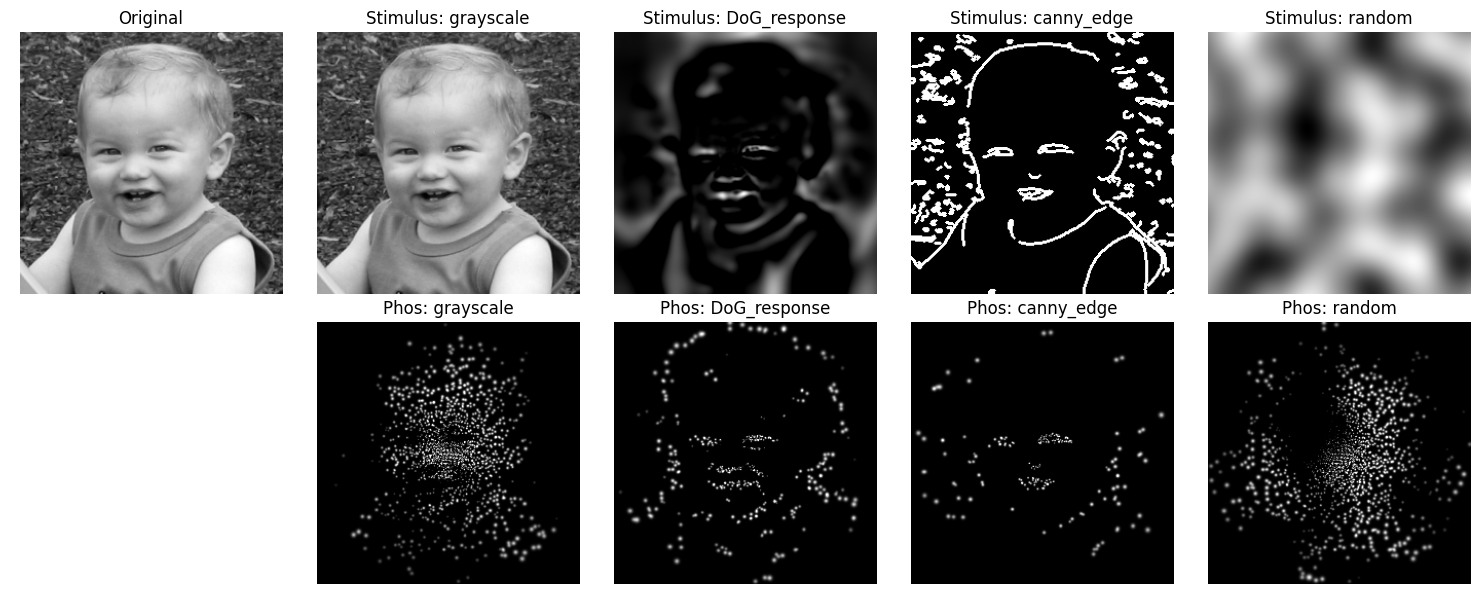

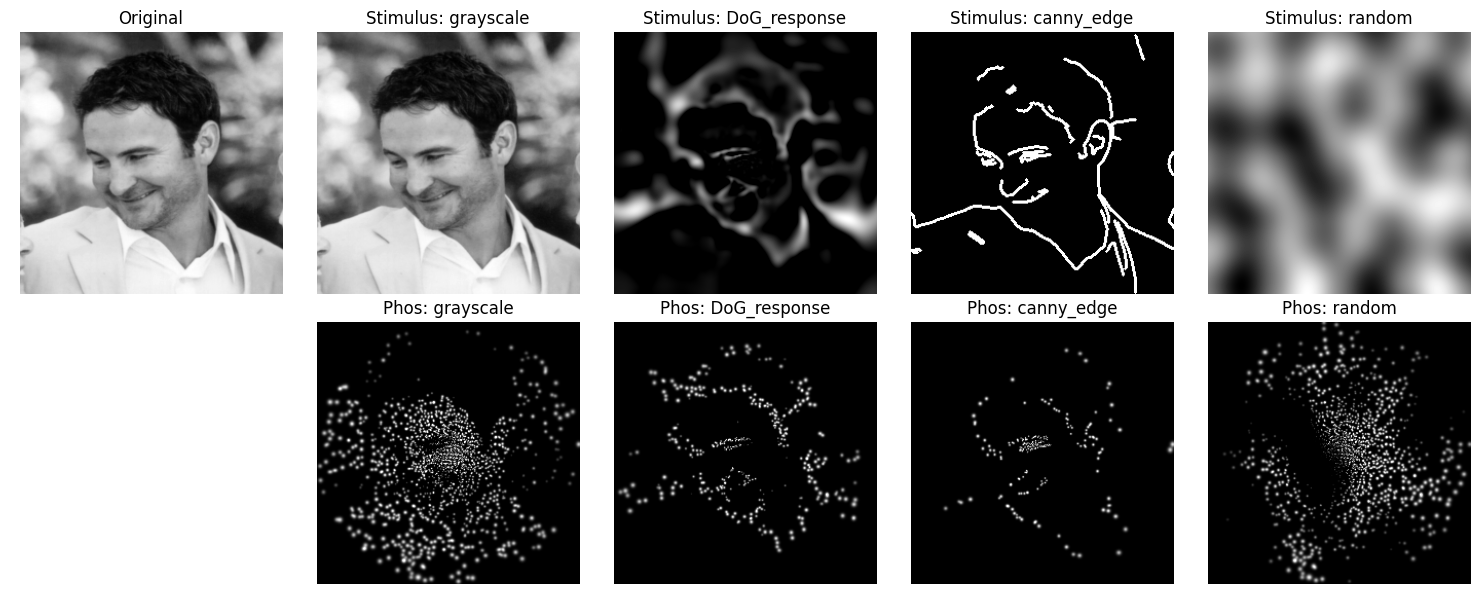

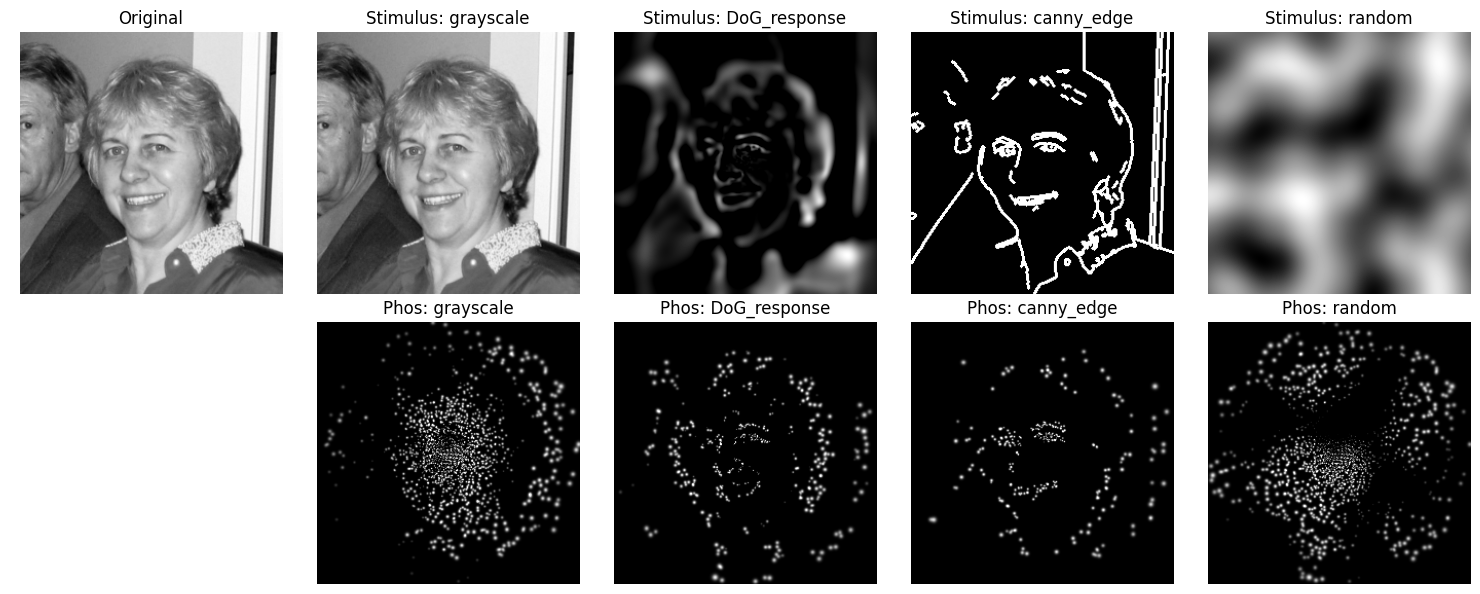

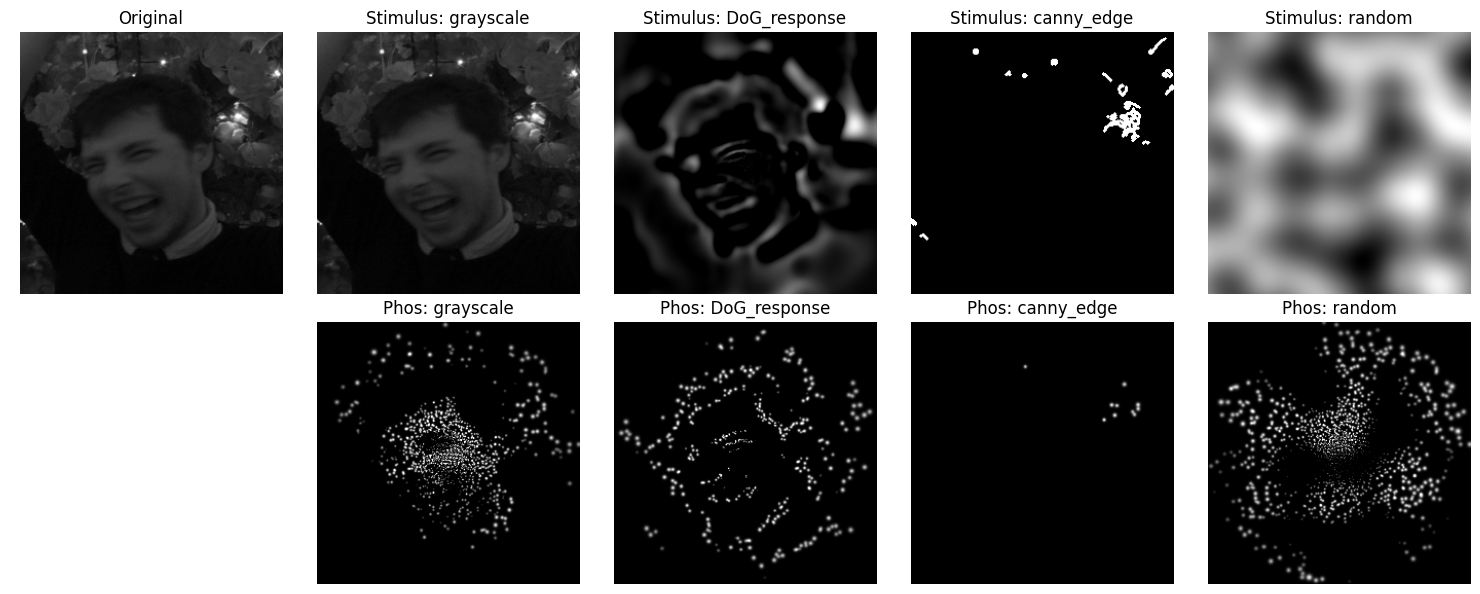

In [244]:
import matplotlib.pyplot as plt

def show_images(idx):
    data   = image_processing_dict[idx]
    # collect all the keys except the raw 'image'
    methods = [k for k in data.keys() if k != 'image']
    n_cols  = 1 + len(methods)   # one column for the original + one for each method

    fig, axes = plt.subplots(2, n_cols,
                             figsize=(3*n_cols, 6),
                             squeeze=False)

    # --- Row 0, Col 0: the original ---
    orig = data['image'][0, 0].cpu().numpy()
    ax = axes[0, 0]
    ax.imshow(orig, cmap='gray')
    ax.set_title('Original')
    ax.axis('off')

    # leave the bottom-left empty (no phos for original)
    axes[1, 0].axis('off')

    for j, key in enumerate(methods, start=1):
        stim = data[key]['stim'][0, 0].cpu().numpy()
        phos = data[key]['phosphenes'][0, 0].cpu().numpy()

        # stimulus in row 0
        ax = axes[0, j]
        ax.imshow(stim, cmap='gray')
        ax.set_title(f'Stimulus: {key}')
        ax.axis('off')

        # phosphenes in row 1
        ax = axes[1, j]
        ax.imshow(phos, cmap='gray')
        ax.set_title(f'Phos: {key}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_images(0)  # Show the first example
show_images(1)  # Show the second example
show_images(2)  # Show the third example
show_images(3)  # Show the fourth example
show_images(4)  # Show the fifth example

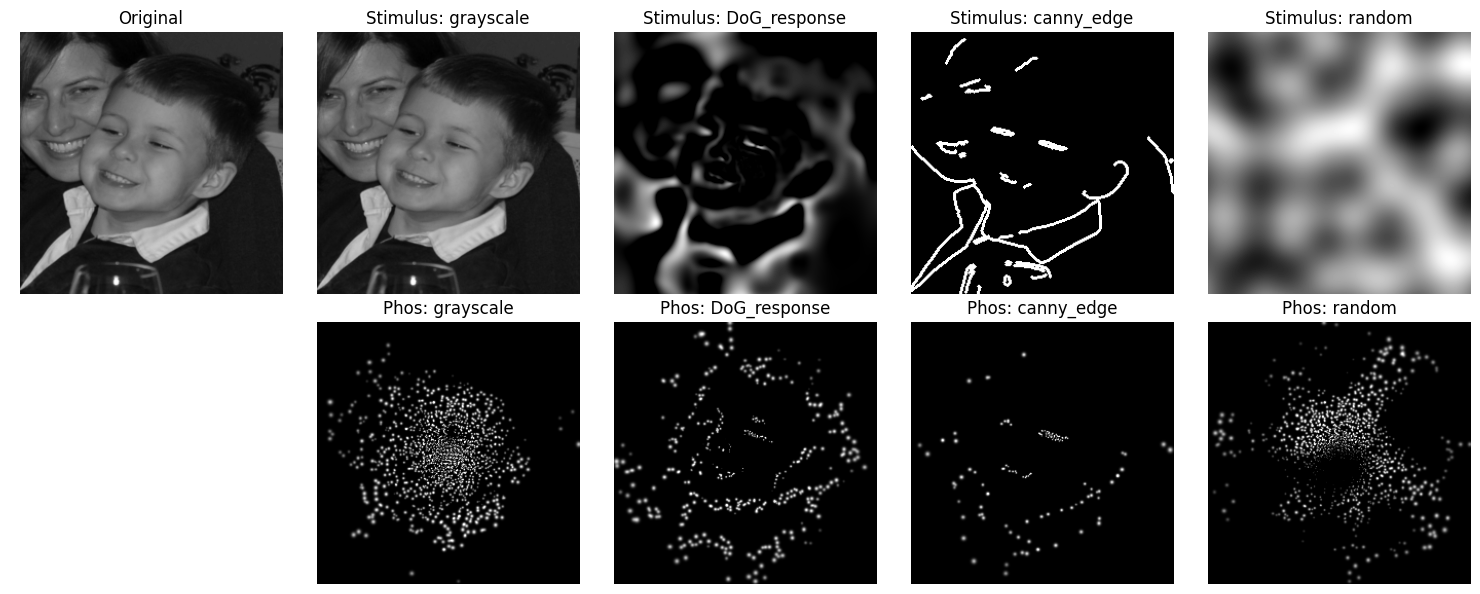

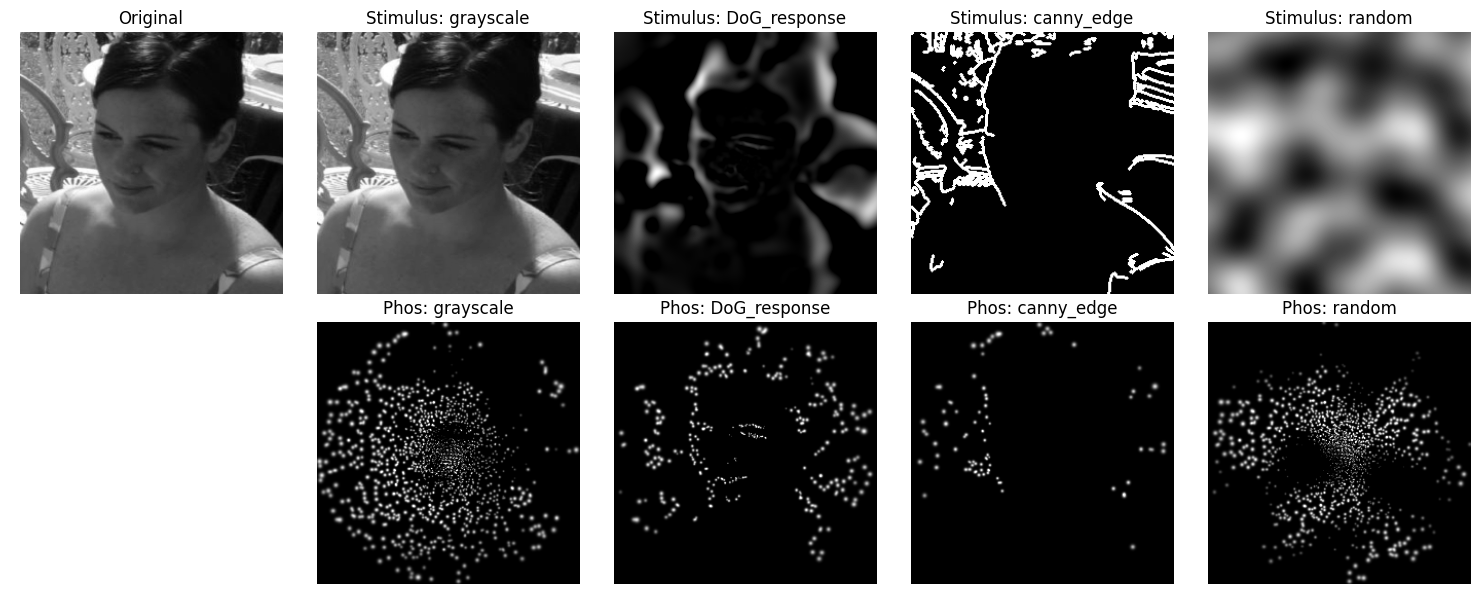

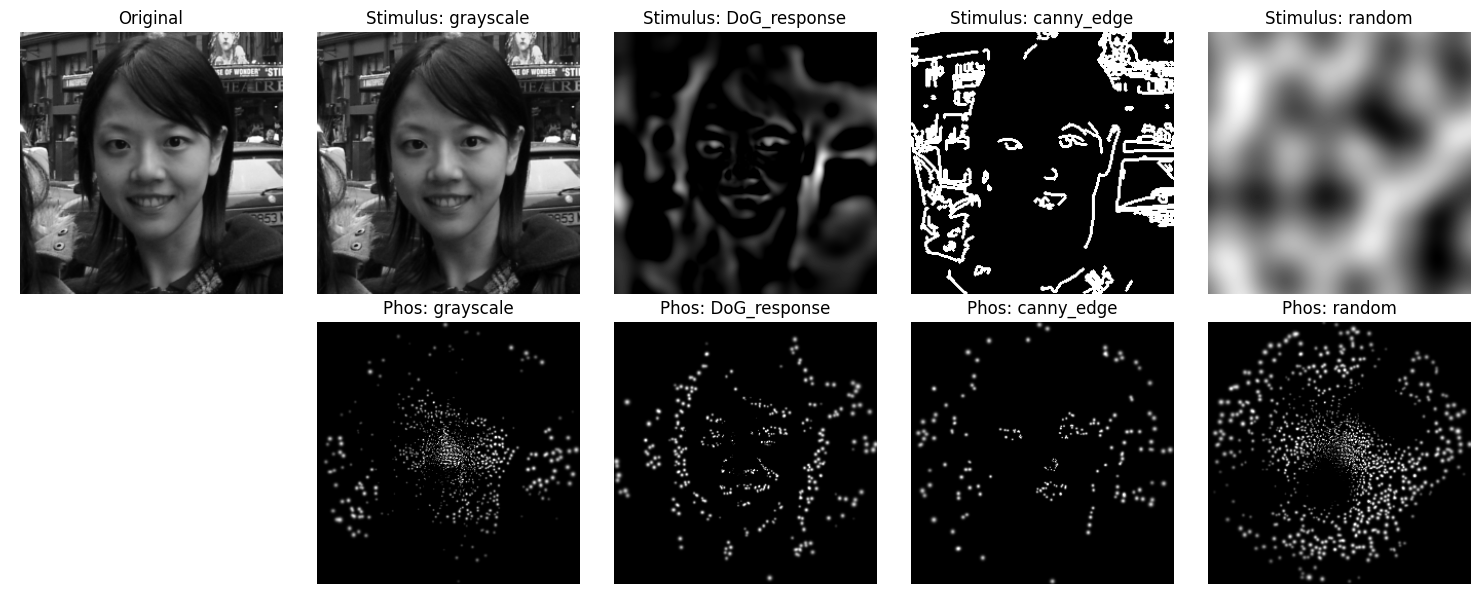

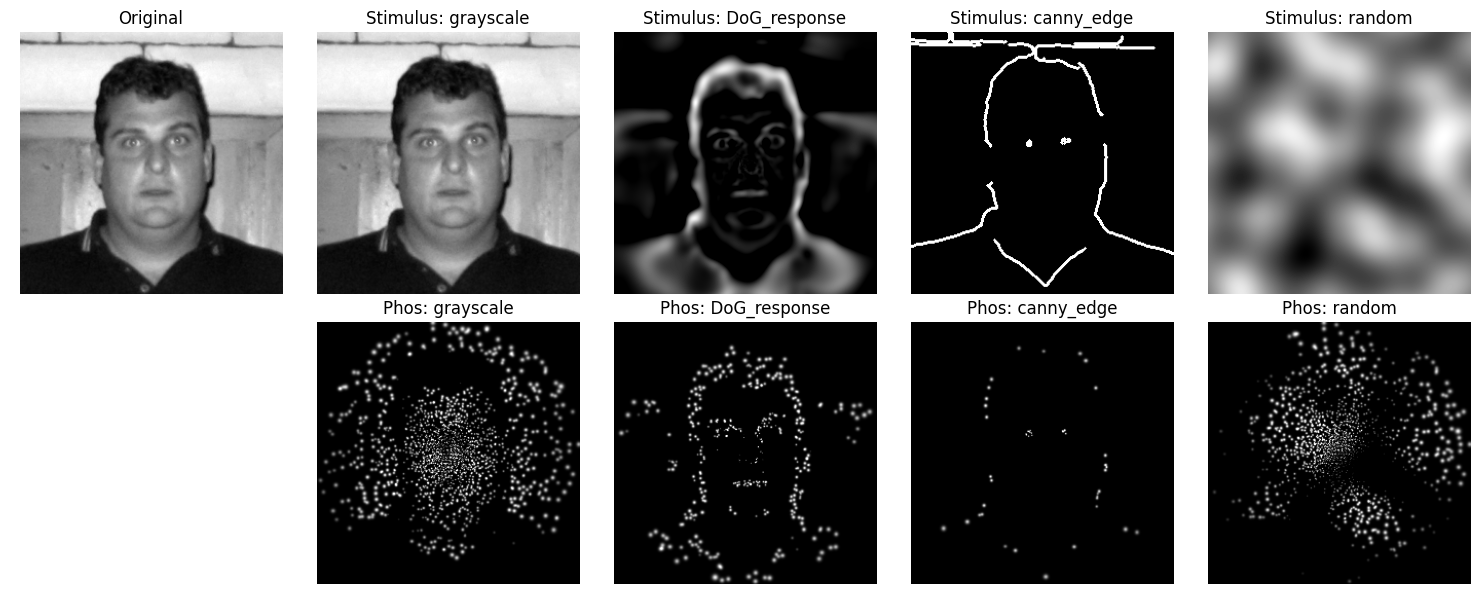

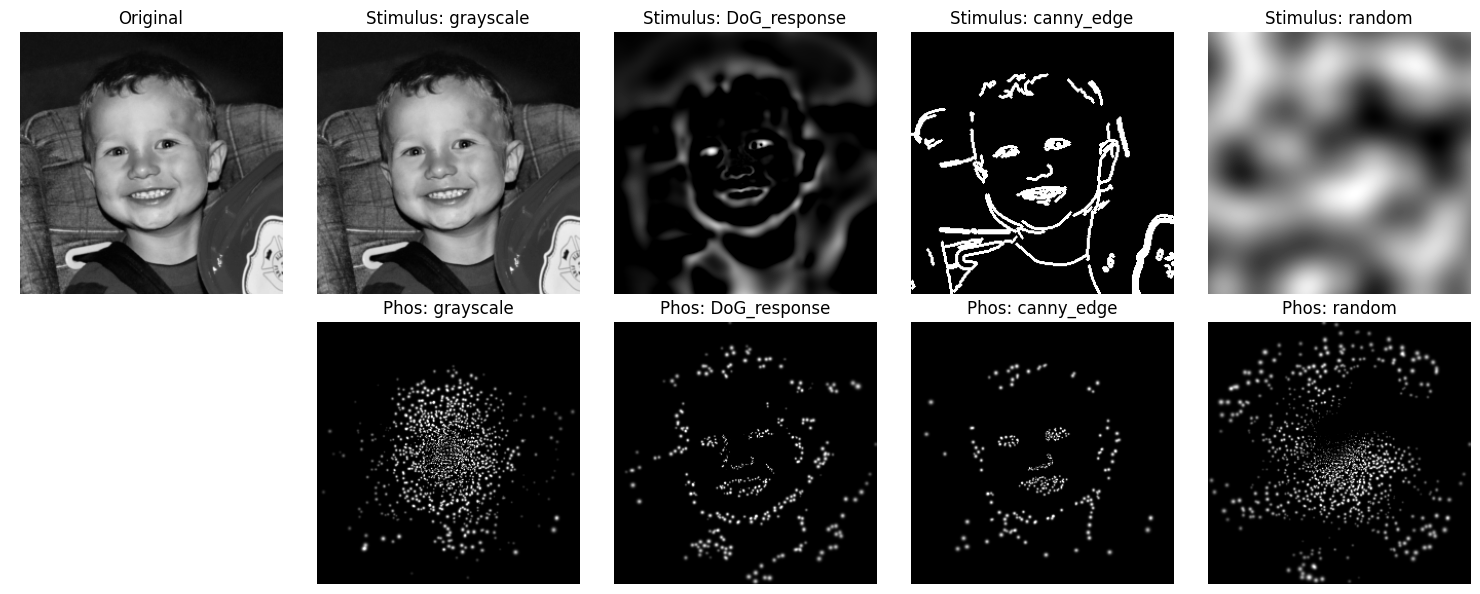

In [245]:
show_images(5)
show_images(6)  # Show the sixth example
show_images(7)  # Show the seventh example
show_images(8)  # Show the eighth example
show_images(9)  # Show the ninth example

In [208]:
# # print all the shapes of the image_processing_dict content
# for idx, data in image_processing_dict.items():
#     print(f"Image {idx}:")
#     print(f"  Original Image Shape: {data['image'].shape}")
#     for key, value in data.items():
#         if key != 'image':
#             print(f"  {key} Stimulus Shape: {value['stim'].shape}")
#             print(f"  {key} Phosphenes Shape: {value['phosphenes'].shape}")
#     print()  # Newline for better readability
    

# Evaluate

In [246]:
import seaborn as sns

def plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title=None, invert_cmap=True):
    """
    Plot three heatmaps showing the loss matrices for:
      1. Stimulus vs. Stimulus (symmetric)
      2. Stimulus vs. Phosphene (non-symmetric)
      3. Phosphene vs. Phosphene (symmetric)
    """
  	# everything to cpu
    stim_stim_matrix = stim_stim_matrix.cpu().numpy()
    stim_phos_matrix = stim_phos_matrix.cpu().numpy()
    phos_phos_matrix = phos_phos_matrix.cpu().numpy()

    sns.set(font_scale=0.7)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    sns.heatmap(stim_stim_matrix, annot=True, fmt=".2f",
                xticklabels=labels_stim, yticklabels=labels_stim, ax=axes[0], cmap='rocket' if not invert_cmap else 'rocket_r', vmin=0)
    axes[0].set_title("Stimulus vs Stimulus")
    axes[0].xaxis.tick_top()

    sns.heatmap(stim_phos_matrix, annot=True, fmt=".2f",
                xticklabels=labels_phos, yticklabels=labels_stim, ax=axes[1], cmap='rocket' if not invert_cmap else 'rocket_r', vmin=0)
    axes[1].set_title("Stimulus vs Phosphene")
    axes[1].xaxis.tick_top()

    sns.heatmap(phos_phos_matrix, annot=True, fmt=".2f",
                xticklabels=labels_phos, yticklabels=labels_phos, ax=axes[2], cmap='rocket' if not invert_cmap else 'rocket_r', vmin=0)
    axes[2].set_title("Phosphene vs Phosphene")
    axes[2].xaxis.tick_top()

    if title:
        plt.suptitle(title, size=16)

    plt.tight_layout()
    plt.show()

In [247]:
def evaluate_loss_matrices(image_processing_dict, loss_fn):
    """
    Evaluate the loss matrices for a given loss function.
    """
    n_images = len(image_processing_dict) # number of images
    n_stimuli = len(image_processing_dict[0].keys())-1 # number of stimuli

    # Initialize the loss matrices
    stim_stim_matrix = torch.zeros(n_stimuli, n_stimuli).cuda()
    stim_phos_matrix = torch.zeros(n_stimuli, n_stimuli).cuda()
    phos_phos_matrix = torch.zeros(n_stimuli, n_stimuli).cuda()

    for image in range(n_images):
        for i, (key, stim_dict) in enumerate([stimuli for stimuli in image_processing_dict[image].items() if stimuli[0] != 'image']):
            if key == 'image':
                continue
            stim = stim_dict['stim'].cuda()
            phos = stim_dict['phosphenes'].cuda()

            for j, (key2, stim_dict2) in enumerate([stimuli for stimuli in image_processing_dict[image].items() if stimuli[0] != 'image']):
                if key2 == 'image':
                    continue
                stim2 = stim_dict2['stim'].cuda()
                phos2 = stim_dict2['phosphenes'].cuda()

                # Compute the loss matrices
                stim_stim_matrix[i, j] += loss_fn(stim, stim2)
                stim_phos_matrix[i, j] += loss_fn(stim, phos2)
                phos_phos_matrix[i, j] += loss_fn(phos, phos2)

    # Normalize the loss matrices by the number of images
    stim_stim_matrix /= n_images
    stim_phos_matrix /= n_images
    phos_phos_matrix /= n_images

    return stim_stim_matrix, stim_phos_matrix, phos_phos_matrix

In [248]:
# Labels for the conditions
labels_stim = ["Gray S", "Canny S", "DoG S", "Random S"]
labels_phos = ["Gray P", "Canny P", "DoG P", "Random P"]

In [249]:
matrix_dict = {}

### Feature Similarity Index Measure (FSIM) 

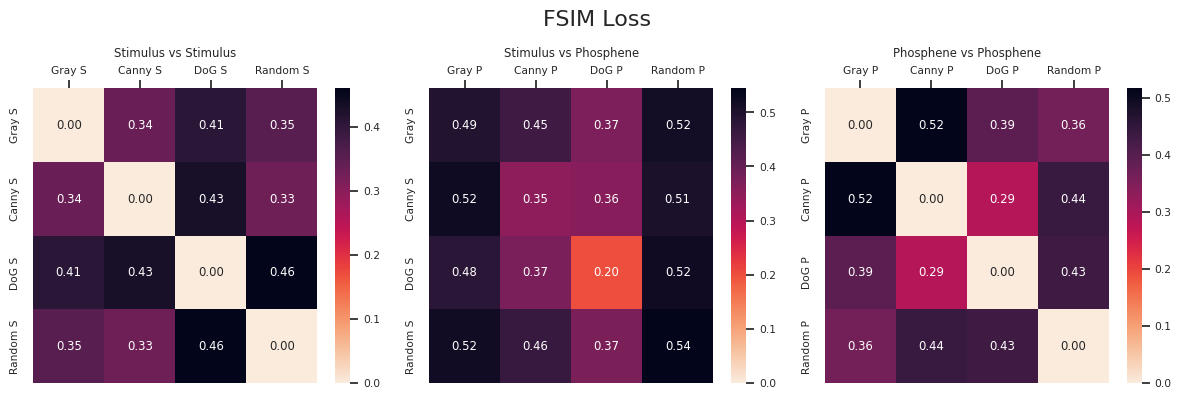

In [250]:
import piq
torch.use_deterministic_algorithms(False)

fsim_loss = piq.FSIMLoss(chromatic=False, min_length=7, scales=4).cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, fsim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='FSIM Loss')

matrix_dict['fsim'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix, 
    'phos_phos': phos_phos_matrix
}

### Learned Perceptual Image Patch Similarity (LPIPS)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


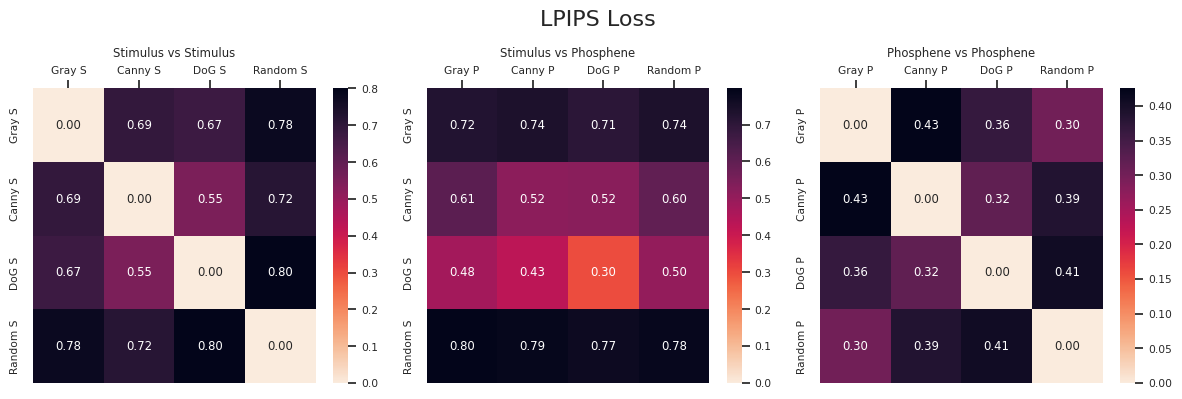

In [251]:
LPIPS_loss = piq.LPIPS()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, LPIPS_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='LPIPS Loss')

matrix_dict['lpips'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}

### Perceptual Image-Error Assessment through Pairwise Preference (PieAPP)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/pieapp.py:171: UserWarning: The original PieAPP supports only RGB images.The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original PieAPP supports only RGB images.'


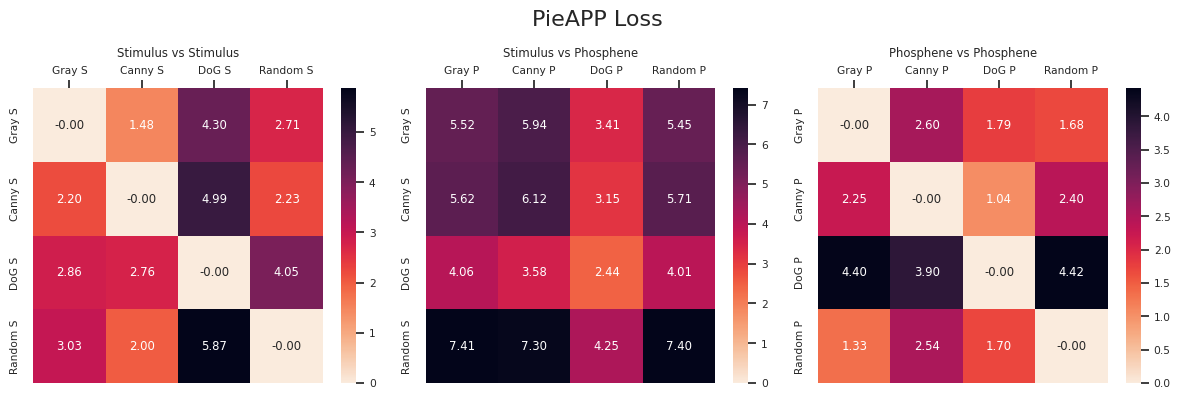

In [252]:
pieapp_loss = piq.PieAPP()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, pieapp_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='PieAPP Loss')

matrix_dict['pieapp'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}


### Deep Image Structure and Texture Similarity (DISTS)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


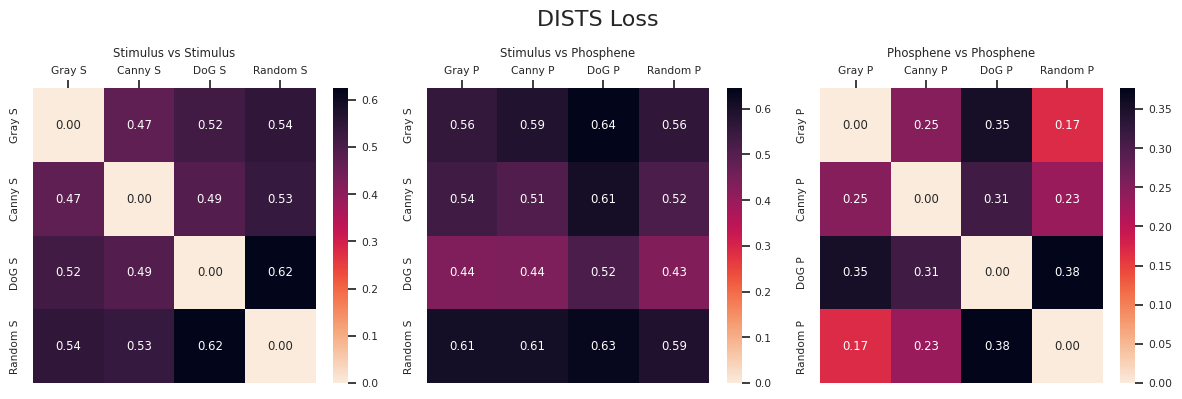

In [253]:
dists_loss = piq.DISTS()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, dists_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='DISTS Loss')

matrix_dict['dists'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}


### Content Loss

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


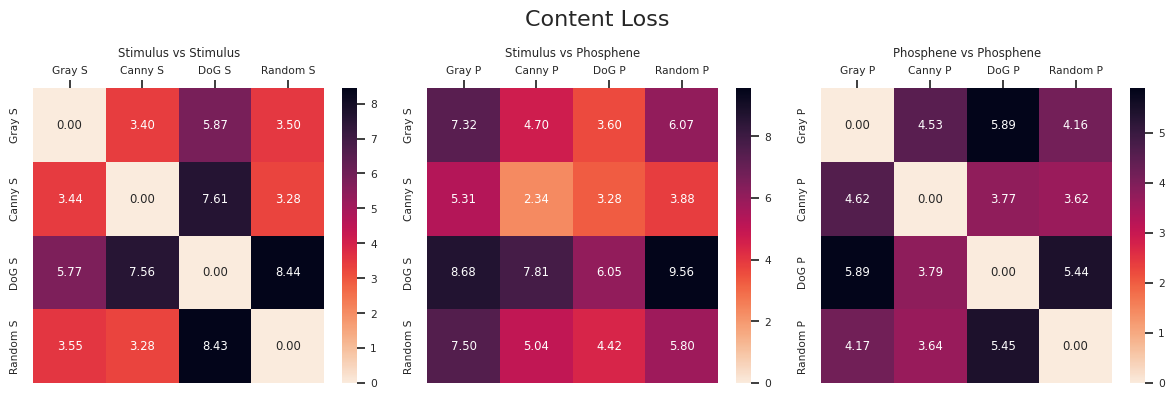

In [254]:
contentloss = piq.ContentLoss(feature_extractor='vgg19', normalize_features=False, layers = ['relu2_2'], distance="swd")

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, contentloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Content Loss')

matrix_dict['content'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}


### Strucural Similarity (SSIM)

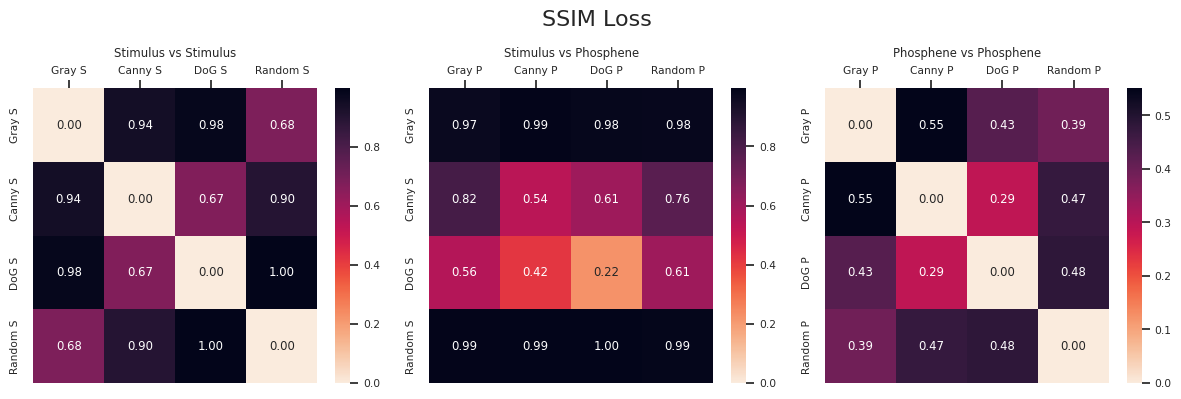

In [255]:
ssim_loss = piq.SSIMLoss()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, ssim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='SSIM Loss')

matrix_dict['ssim'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}

### Multi-Scale Structural Similarity (MS-SSIM)

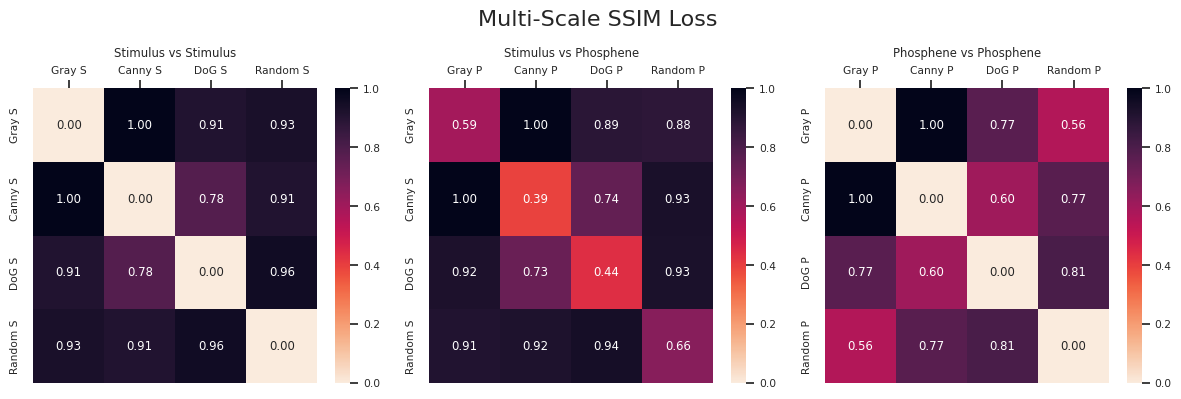

In [256]:
msssim_loss = piq.MultiScaleSSIMLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, msssim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Multi-Scale SSIM Loss')

matrix_dict['msssim'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}

### Information Content Weighted Structural Similarity (IW-SSIM)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/iw_ssim.py:256: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  lo_x = F.conv2d(input=lo_x, weight=kernel_t.unsqueeze(0), padding=0)[:, :, ::2, :]
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/iw_ssim.py:272: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  hi_x = F.conv2d(input=hi_x, weight=kernel_t.unsqueeze(0), padding=0)[:, :, :x.size(-2), :]
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/iw_ssim.py:253: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descripto

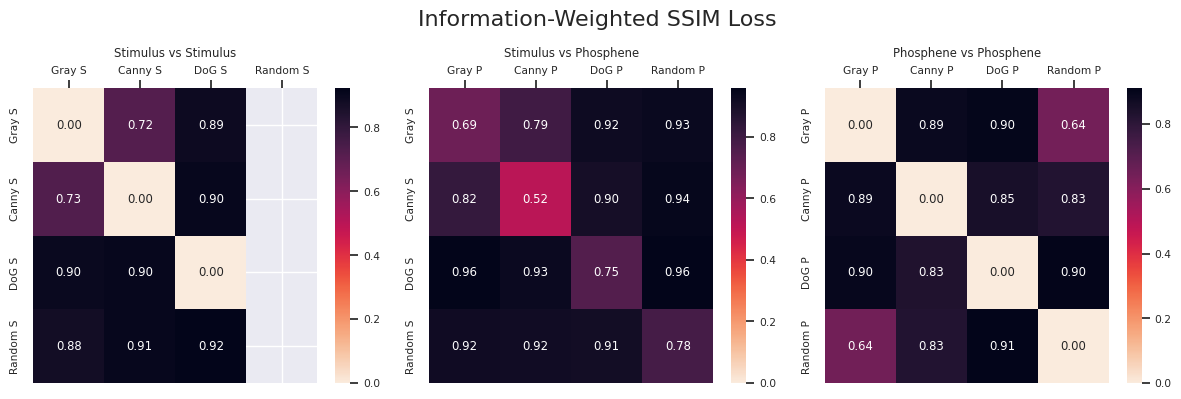

In [257]:
iwssim_loss = piq.InformationWeightedSSIMLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, iwssim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Information-Weighted SSIM Loss')

matrix_dict['iwssim'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}


### Visual Information Fidelity (VIFp)

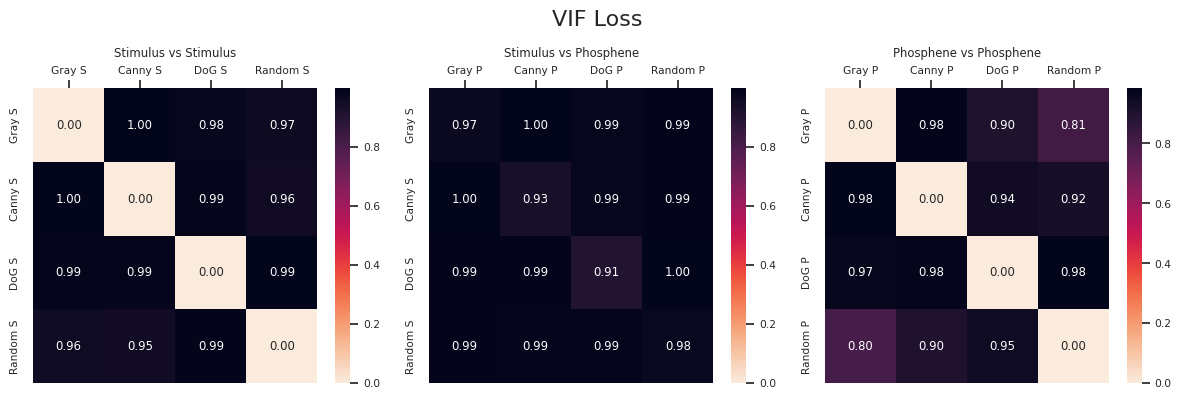

In [258]:
vifloss = piq.VIFLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, vifloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='VIF Loss')

matrix_dict['vif'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}

### Spectral Residual based Similarity Measure (SR-SIM)

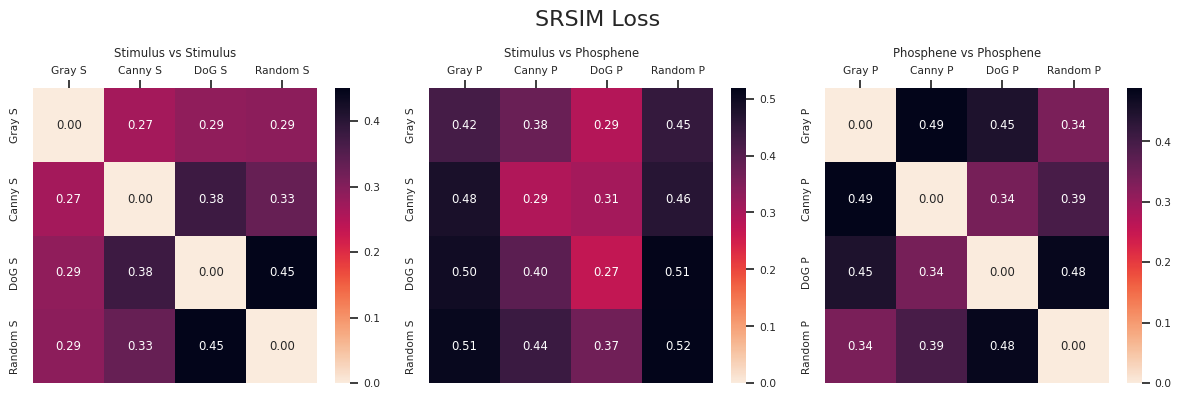

In [259]:
srsimloss = piq.SRSIMLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, srsimloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='SRSIM Loss')

matrix_dict['srsim'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}

### Gradient Magnitude Similarity Deviation (GMSD)

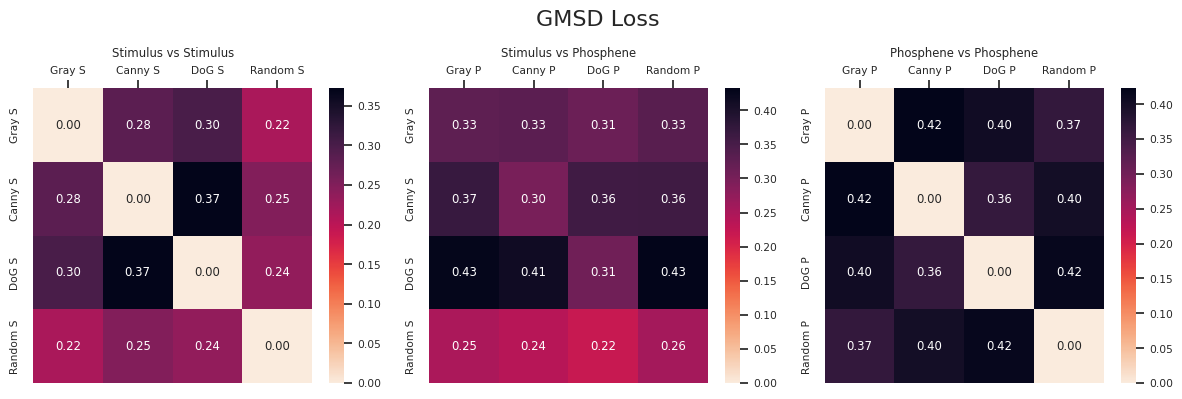

In [260]:
loss = piq.GMSDLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='GMSD Loss')

matrix_dict['gmsd'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}

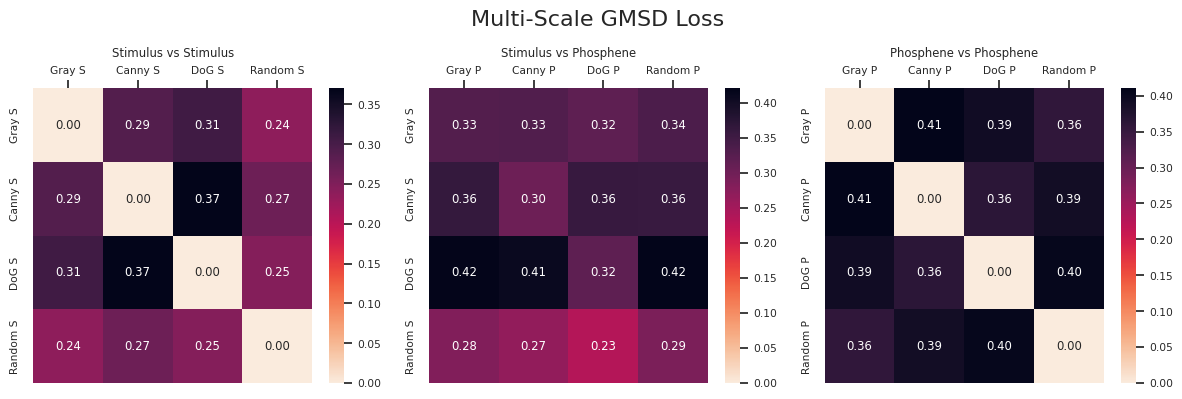

In [261]:
loss = piq.MultiScaleGMSDLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Multi-Scale GMSD Loss')

matrix_dict['ms_gmsd'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}

### Visual Saliency-induced Index (VSI)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/vsi.py:63: UserWarning: The original VSI supports only RGB images. The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original VSI supports only RGB images. The input images were converted to RGB by copying '


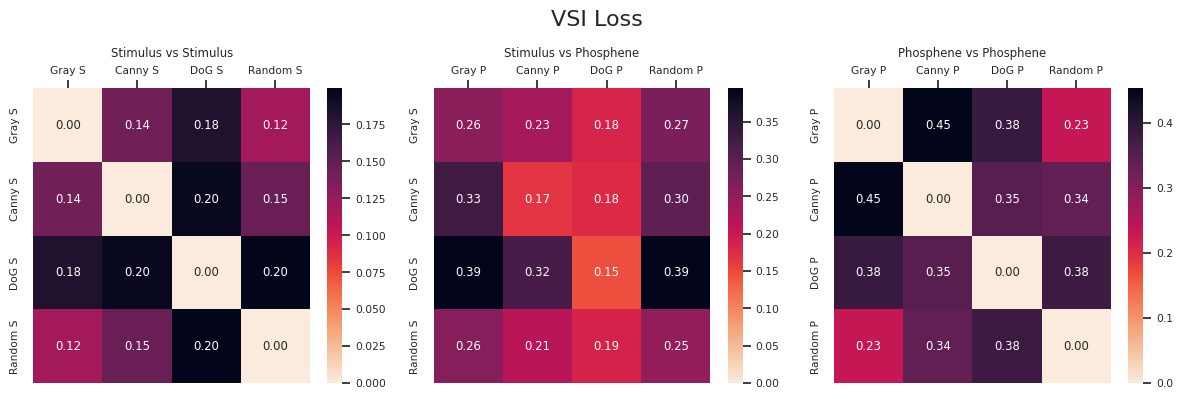

In [262]:
vsiloss = piq.VSILoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, vsiloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='VSI Loss')

matrix_dict['vsi'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}


### DCT Subband Similarity Index (DSS)

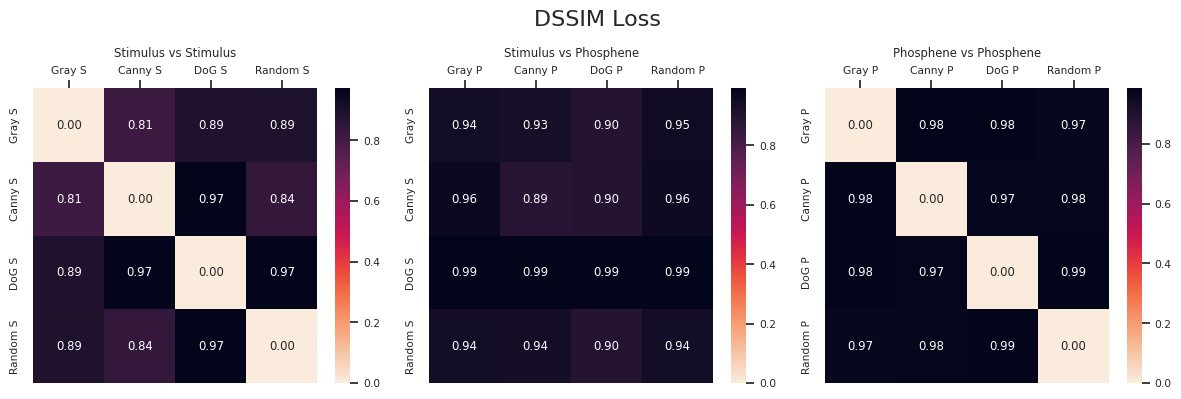

In [263]:
dssloss = piq.DSSLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, dssloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='DSSIM Loss')

matrix_dict['dssim'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}

### Haar Perceptual Similarity Index (HaarPSI)

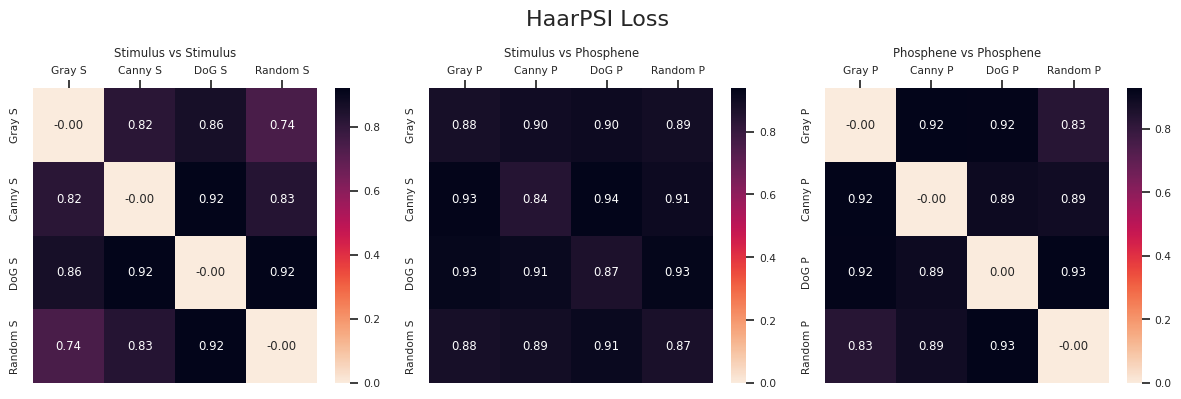

In [264]:
haarloss = piq.HaarPSILoss(scales=3).cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, haarloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='HaarPSI Loss')

matrix_dict['haarpsi'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}


### Mean Deviation Similarity Index (MDSI)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/mdsi.py:66: UserWarning: The original MDSI supports only RGB images. The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original MDSI supports only RGB images. The input images were converted to RGB by copying '


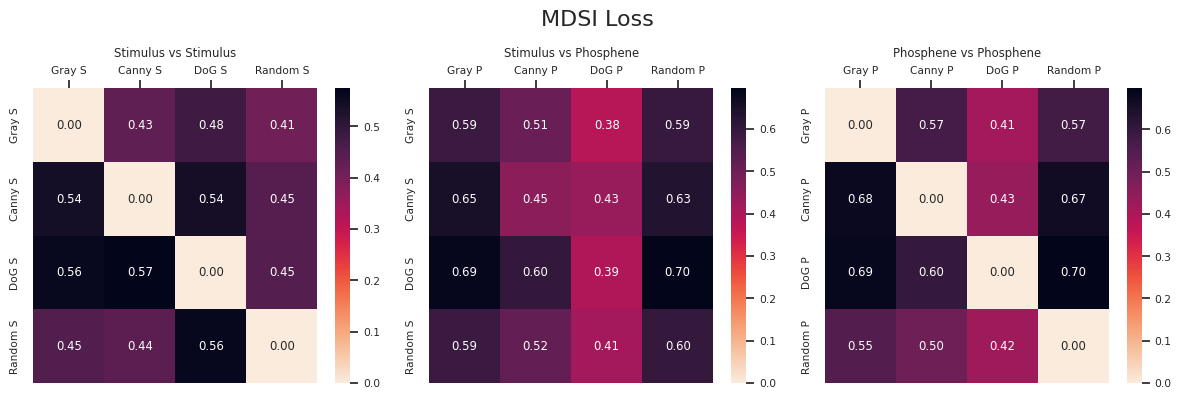

In [265]:
mdsiloss = piq.MDSILoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, mdsiloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='MDSI Loss')

matrix_dict['mdsi'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}

# Save results as CSV

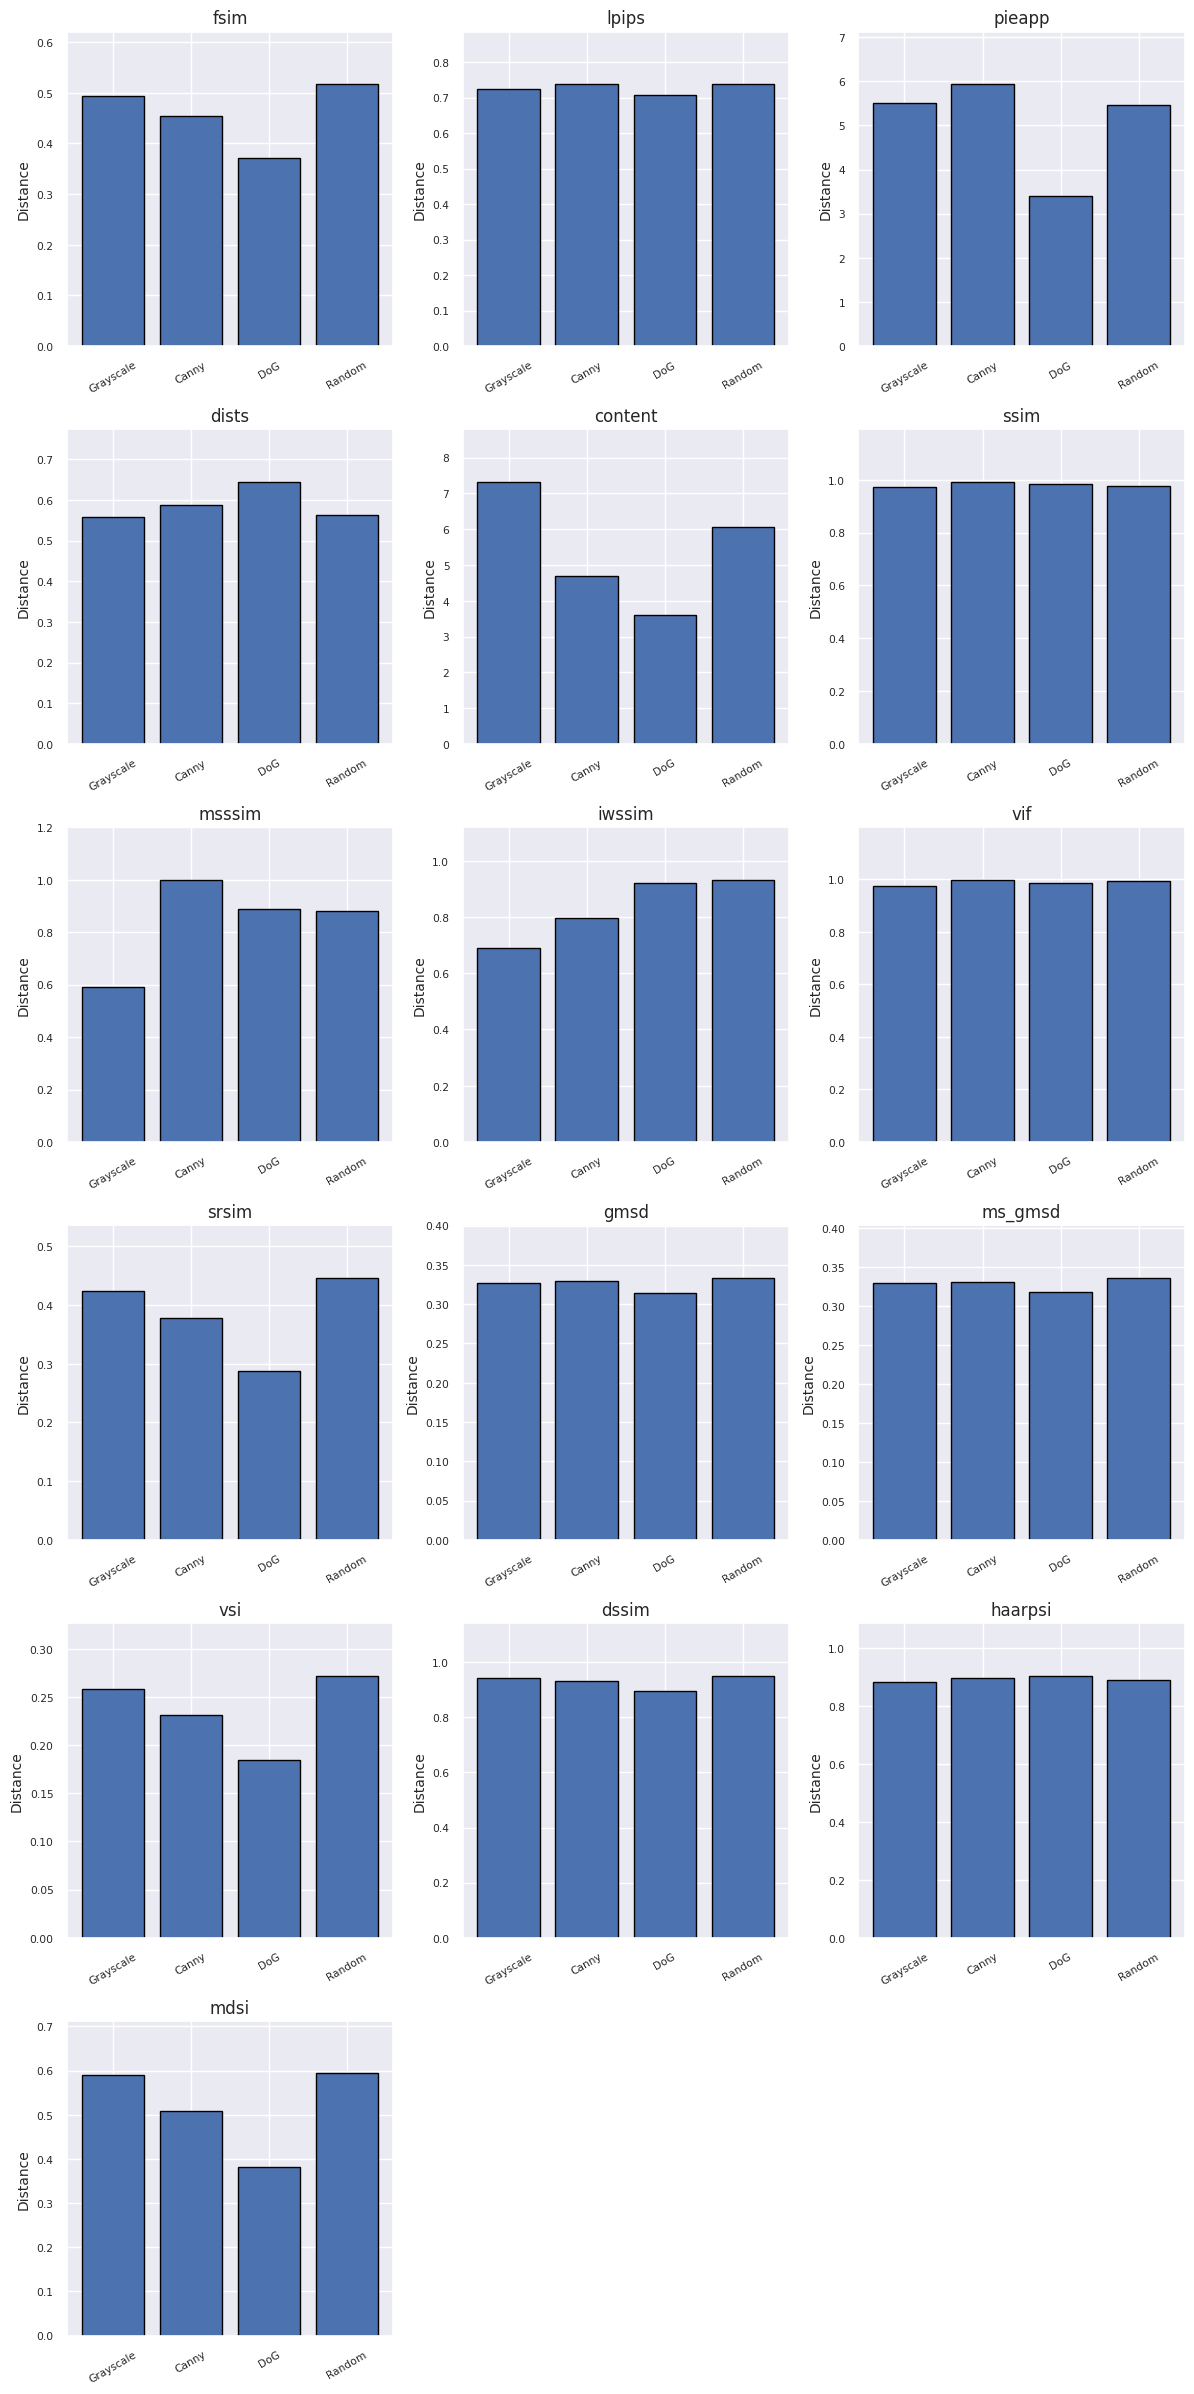

In [266]:
import numpy as np
import matplotlib.pyplot as plt

# If you haven't already, gather your matrix_dict into Python:
# Example placeholder – replace with your real dict
# matrix_dict = {
#     'fsim':        {'stim_phos': ...},
#     'ssim':        {'stim_phos': ...},
#     'lpips':       {'stim_phos': ...},
#     # etc...
# }

methods = ['Grayscale', 'Canny', 'DoG', 'Random']
metrics = list(matrix_dict.keys())

# Plot a bar chart per metric
n = len(metrics)
cols = 3
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    # Extract the 0th row of stim_phos: original image vs each phosphene map
    stim_phos = matrix_dict[metric]['stim_phos']
    # If it's a torch tensor, move to CPU and convert to numpy:
    if hasattr(stim_phos, 'cpu'):
        stim_phos = stim_phos.cpu().numpy()
    values = stim_phos[0, :]

    ax.bar(methods, values, edgecolor='black')
    ax.set_title(metric, fontsize=12)
    ax.set_ylabel('Distance', fontsize=10)
    ax.set_ylim(0, values.max() * 1.2)
    ax.tick_params(axis='x', rotation=30)

# Remove any unused axes
for ax in axes[len(metrics):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

/scratch-local/mappel.12936260/ipykernel_1241997/3691202934.py:25: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distances, method='complete')


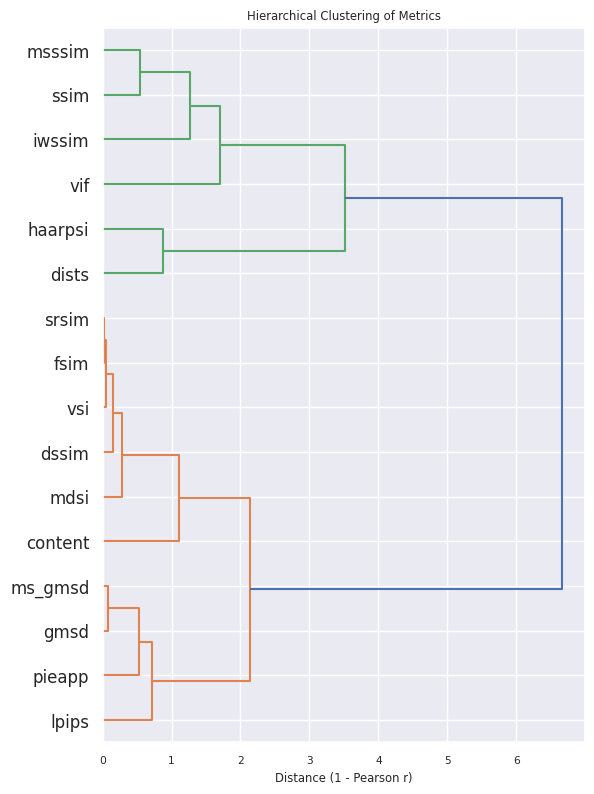

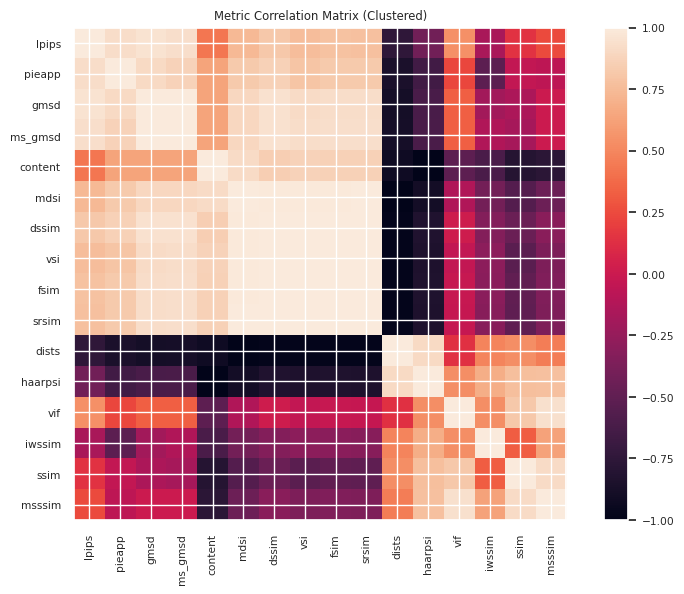

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# Assume matrix_dict is already defined in the notebook:
# It should be a dict: metric_name -> {'stim_phos': tensor(4x4), ...}

# Extract metric names and the "original → phosphene" vectors
metrics = list(matrix_dict.keys())
values = []
for m in metrics:
    mat = matrix_dict[m]['stim_phos']
    if hasattr(mat, 'cpu'):
        mat = mat.cpu().numpy()
    # take row corresponding to the original stimulus (index 0)
    values.append(mat[0, :])
values = np.stack(values)  # shape: (n_metrics, 4)

# 1) Compute correlation matrix across metrics
corr = np.corrcoef(values)

# 2) Hierarchical clustering on the correlation distances
#    distance = 1 - correlation
distances = 1 - corr
Z = linkage(distances, method='complete')

# Plot dendrogram
plt.figure(figsize=(6, 8))
dendrogram(Z, labels=metrics, orientation='right')
plt.title('Hierarchical Clustering of Metrics')
plt.xlabel('Distance (1 - Pearson r)')
plt.tight_layout()
plt.show()

# 3) Reorder metrics by clustering leaves and plot correlation heatmap
order = dendrogram(Z, labels=metrics, no_plot=True)['leaves']
reordered_corr = corr[np.ix_(order, order)]
reordered_labels = [metrics[i] for i in order]

plt.figure(figsize=(8, 6))
plt.imshow(reordered_corr, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(order)), reordered_labels, rotation=90)
plt.yticks(range(len(order)), reordered_labels)
plt.title('Metric Correlation Matrix (Clustered)')
plt.tight_layout()
plt.show()


In [268]:
# Store all losses in a df
import pandas as pd
losses = []
for metric, matrices in matrix_dict.items():
    stim_phos = matrices['stim_phos']
    if hasattr(stim_phos, 'cpu'):
        stim_phos = stim_phos.cpu().numpy()
    # take row corresponding to the original stimulus (index 0)
    values = stim_phos[0, :]
    for i, method in enumerate(labels_stim):
        losses.append({
            'metric': metric,
            'method': method,
            'loss': values[i]
        })
loss_df = pd.DataFrame(losses)

print(loss_df)

     metric    method      loss
0      fsim    Gray S  0.494487
1      fsim   Canny S  0.453582
2      fsim     DoG S  0.370841
3      fsim  Random S  0.517277
4     lpips    Gray S  0.724341
..      ...       ...       ...
59  haarpsi  Random S  0.890826
60     mdsi    Gray S  0.588925
61     mdsi   Canny S  0.507435
62     mdsi     DoG S  0.382584
63     mdsi  Random S  0.593485

[64 rows x 3 columns]
